# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        items[movie_id] = movie_plot

len(items)

9125

In [2]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [3]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Source/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

Torch Song Trilogy (1988)

Tony Award-winning actor and playwright Harvey Fierstein re-creates his role as the unsinkable Arnold Beckoff in this film adaptation of the smash Broadway play TORCH SONG TRILOGY. A very personal story that is both funny and poignant, TORCH SONG TRILOGY chronicles a New Yorker's search for love, respect and tradition in a world that seems not especially made for him. From Arnold's hilarious steps toward domestic bliss with a reluctant school teacher, to his first truly promising love affair with a young fashion model, Arnold's greatest challenge remains his complicated relationship with his mother. But armed with a keenly developed sense of humor and oftentimes piercing wit, Arnold continues to test the commonly accepted terms of endearment--and endurance--in a universally affecting story that confirms that happiness is well worth carrying a torch for.

['tony', 'award-winning', 'actor', 'and', 'playwright', 'harvey', 'fierstein', 're-creates', 'his', 'role'

In [5]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

38388

Documents size:

9125

Most common words (+UNK):

[(',', 39543), ('the', 37983), ('.', 29809), ('a', 24721), ('to', 22220)]

Document example: id=4555

Torch Song Trilogy (1988) 

Tony Award-winning actor and playwright Harvey Fierstein re-creates his role as the unsinkable Arnold Beckoff in this film adaptation of the smash Broadway play TORCH SONG TRILOGY. A very personal story that is both funny and poignant, TORCH SONG TRILOGY chronicles a New Yorker's search for love, respect and tradition in a world that seems not especially made for him. From Arnold's hilarious steps toward domestic bliss with a reluctant school teacher, to his first truly promising love affair with a young fashion model, Arnold's greatest challenge remains his complicated relationship with his mother. But armed with a keenly developed sense of humor and oftentimes piercing wit, Arnold continues to test the commonly accepted terms of endearment--and endurance--in a universally affecting 

In [6]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (5953, award-winning) -> (791, tony)
0: (5953, award-winning) -> (825, actor)
0: (825, actor) -> (6, and)
0: (825, actor) -> (5953, award-winning)
0: (6, and) -> (825, actor)
0: (6, and) -> (3258, playwright)
0: (3258, playwright) -> (6, and)
0: (3258, playwright) -> (2617, harvey)
0: (2617, harvey) -> (27405, fierstein)
0: (2617, harvey) -> (3258, playwright)

2nd Batch:

0: (27405, fierstein) -> (15596, re-creates)
0: (27405, fierstein) -> (2617, harvey)
0: (15596, re-creates) -> (27405, fierstein)
0: (15596, re-creates) -> (10, his)
0: (10, his) -> (15596, re-creates)
0: (10, his) -> (932, role)
0: (932, role) -> (19, as)
0: (932, role) -> (10, his)
0: (19, as) -> (2, the)
0: (19, as) -> (932, role)

3rd Batch:

0: (2, the) -> (19, as)
0: (2, the) -> (17501, unsinkable)
0: (17501, unsinkable) -> (3041, arnold)
0: (17501, unsinkable) -> (2, the)
0: (3041, arnold) -> (21740, beckoff)
0: (3041, arnold) -> (17501, unsinkable)
0: (21740, beckoff) -> (3041, arnold)
0: (2174

In [7]:
import tensorflow as tf

class Doc2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate=0.2):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width))
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width))
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        #self.train = optimizer.minimize(self.loss, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm


class NearestWordsQuery:
    
    def __init__(self, model, mapping, words):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(model.words_embeddings, input_words)
        self.similarity = tf.matmul(words_embeddings, model.words_embeddings, transpose_b=True)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session, k=8):
        similarity = session.run(self.similarity)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest = (-similarity[i, :]).argsort()[1:k+1]
            nearest_words = ', '.join(self.word_from_idx(k) for k in nearest)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, model, mapping, docs):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(model.docs_embeddings, input_docs)
        self.similarity = tf.matmul(docs_embeddings, model.docs_embeddings, transpose_b=True)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session, k=3):
        similarity = session.run(self.similarity)
        for i, doc_idx in enumerate(self.docs):
            nearest = (-similarity[i, :]).argsort()[1:k+1]            
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, near_idx in enumerate(nearest):
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {} ] {}\n\n{}\n'.format(n+1, near_title, near_text))
            print('---\n')


class Doc2vecTrainer:
    
    #dataset
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
    
    def train(self, num_epochs=1):
        data_reader = self.data_reader()
        
        with tf.Graph().as_default(), tf.Session() as session:
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            init = tf.global_variables_initializer()
            session.run(init)
            print('Initialized.\n')
            
            train_ops = [model.train, model.loss]
            average_loss = 0
            
            step = 0
            last_epoch = data_reader.num_epoch
            while data_reader.num_epoch < num_epochs:
                batch_docs, batch_data, batch_labels = data_reader.read()
                feed_dict = {
                    model.input_docs: batch_docs,
                    model.input_data: batch_data,
                    model.input_labels: batch_labels,
                }
                
                _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                average_loss += loss_val

                if step % 5000 == 0:
                    if step > 0:
                        average_loss /= 5000
                    print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                    average_loss = 0
                                
                step += 1
                
                if data_reader.num_epoch != last_epoch:
                    last_epoch = data_reader.num_epoch
                    print()
                    print('Epoch', last_epoch)
                    print()
                    doc_query.run(session)
                    word_query.run(session)
                    print()

            print('Total steps: {:,d}'.format(step))
            
            docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Doc2vecModel(self.corpus.documents_size,
                            self.corpus.vocabulary_size,
                            self.embedding_size,
                            self.num_sampled)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)


In [8]:
%%time

doc_trainer = Doc2vecTrainer(
    train_corpus,
    batch_size = 16,
    skip_window = 2,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 100)     # Number of negative examples to sample.

docs_embeddings = doc_trainer.train(num_epochs=25)

Initialized.

Average loss at step 0: 382.555
Average loss at step 5,000: 78.159
Average loss at step 10,000: 25.527
Average loss at step 15,000: 19.614
Average loss at step 20,000: 16.422
Average loss at step 25,000: 14.778
Average loss at step 30,000: 14.961
Average loss at step 35,000: 13.422
Average loss at step 40,000: 12.797
Average loss at step 45,000: 11.914
Average loss at step 50,000: 11.917
Average loss at step 55,000: 11.148
Average loss at step 60,000: 10.668
Average loss at step 65,000: 10.263
Average loss at step 70,000: 10.257
Average loss at step 75,000: 10.036
Average loss at step 80,000: 10.009
Average loss at step 85,000: 9.433
Average loss at step 90,000: 9.372

Epoch 1

Boy in the Striped Pajamas, The (Boy in the Striped Pyjamas, The) (2008)

Set during WWII, a story seen through the innocent eyes of Bruno, the eight-year-old son of the commandant at a German concentration camp, whose forbidden friendship with a Jewish boy on the other side of the camp fence has s

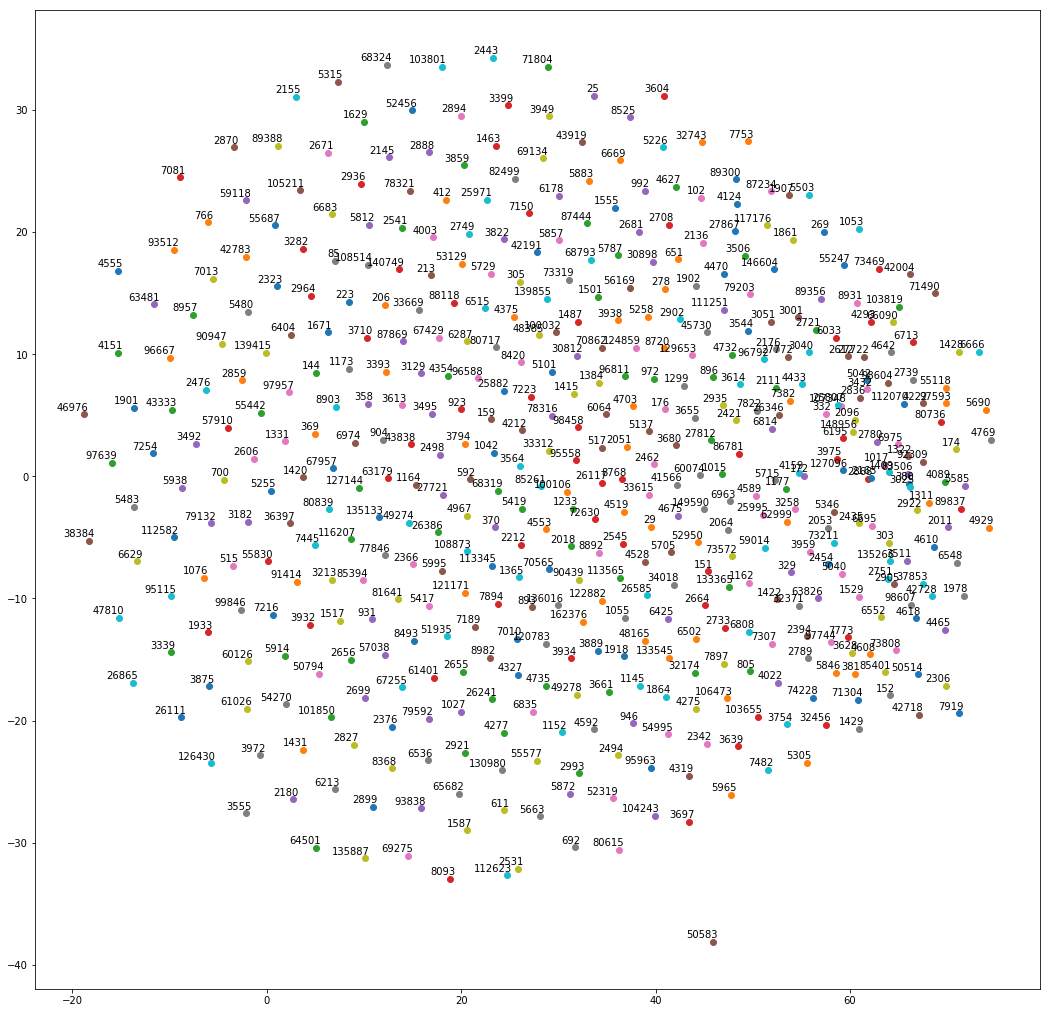

In [9]:
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(docs_embeddings[:plot_only,:])
labels = list(train_corpus.document_from_idx[i] for i in range(plot_only))

plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

plt.show()